## Exploring individual events ##

Looking at the meteorology which drives the extremes in demand net wind, for both the observed and the model time series.

E.g. 2010 for the obs

In [1]:
# Import local modules
import os
import sys
import glob
import importlib

# Import external modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import cartopy.crs as ccrs
import cftime
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FuncFormatter

# import tqdm
from tqdm import tqdm

ERROR 1: PROJ: proj_create_from_database: Open of /apps/jasmin/jaspy/mambaforge_envs/jaspy3.10/mf-22.11.1-4/envs/jaspy3.10-mf-22.11.1-4-r20230718/share/proj failed


In [2]:
from plotting_functions import *

In [3]:
# Set up the global variables
saved_dir = "/home/users/benhutch/unseen_multi_year/dfs"
dfs_dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs"

# set up the fnames - daily wind power
daily_obs_wind_fname = (
    "United_Kingdom_wind_power_df_test_ons_ofs_1960_2018_NDJFM_obs.csv"
)
daily_model_wind_fname = "United_Kingdom_wind_power_df_test_ons_ofs_1960_2018_NDJFM.csv"

# set up the fnames - daily demand
daily_model_demand_fname = "model_demand_NDJFM_daily.csv"
daily_obs_demand_fname = "obs_wd_demand_1960_2019_United_Kingdom.csv"

In [4]:
# load the observed data
daily_obs_wind = pd.read_csv(os.path.join(saved_dir, daily_obs_wind_fname))
daily_obs_demand = pd.read_csv(os.path.join(dfs_dir, daily_obs_demand_fname))

In [5]:
daily_obs_wind.head()

,Unnamed: 0,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen
0,1960-11-01,11.325152,0.699079,0.826896,10.392515,12.201679
1,1960-11-02,14.248714,0.804985,0.874877,11.966914,12.909687
2,1960-11-03,10.112684,0.553986,0.661860,8.235563,9.766404
3,1960-11-04,8.534932,0.419052,0.496145,6.229633,7.321120
4,1960-11-05,7.439478,0.249140,0.326865,3.703711,4.823227


In [6]:
daily_obs_demand.head()

,Unnamed: 0,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960-11-01,9.970184,5.529816,0.0,39.190225
1,1960-11-02,8.484436,7.015564,0.0,40.300983
2,1960-11-03,6.850250,8.649750,0.0,41.522715
3,1960-11-04,7.034576,8.465424,0.0,41.384911
4,1960-11-05,7.439514,8.060486,0.0,41.082176


In [7]:
# join by using the "Unnamed: 0" column
obs_df = pd.merge(daily_obs_wind, daily_obs_demand, on="Unnamed: 0")

In [8]:
# set "Unnamed: 0" as datetime
obs_df["Unnamed: 0"] = pd.to_datetime(obs_df["Unnamed: 0"])

# set the datetime as the index
obs_df.set_index("Unnamed: 0", inplace=True)

# remove the name of the index
obs_df.index.name = None

In [9]:
obs_df.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
1960-11-01,11.325152,0.699079,0.826896,10.392515,12.201679,9.970184,5.529816,0.0,39.190225
1960-11-02,14.248714,0.804985,0.874877,11.966914,12.909687,8.484436,7.015564,0.0,40.300983
1960-11-03,10.112684,0.553986,0.661860,8.235563,9.766404,6.850250,8.649750,0.0,41.522715
1960-11-04,8.534932,0.419052,0.496145,6.229633,7.321120,7.034576,8.465424,0.0,41.384911
1960-11-05,7.439478,0.249140,0.326865,3.703711,4.823227,7.439514,8.060486,0.0,41.082176


In [10]:
# Calculate the demand net wind
obs_df["demand_net_wind"] = obs_df["United_Kingdom_demand"] - (
    obs_df["ons_gen"] + obs_df["ofs_gen"]
)

In [11]:
# make a copy of the obs_df
obs_df_copy = obs_df.copy()

# perform a rolling climatology
rolling_climatology = obs_df_copy.rolling(
    window="14D", min_periods=1, center=False
).mean()

# add a new column for the day of the year
rolling_climatology["day_of_year"] = rolling_climatology.index.dayofyear

# calculate the mean for each day of the year
climatology = rolling_climatology.groupby("day_of_year").mean()

In [12]:
# subset climatology to days of the year in NDJFM
climatology_ND = climatology.loc[(climatology.index >= 305)]
climatology_JFM = climatology.loc[(climatology.index <= 90)]

# concatenate the two dataframes
climatology_NDJFM = pd.concat([climatology_ND, climatology_JFM])

In [13]:
# add a new column for winter day of the year
# which is just the index of each row, e.g. 0, 1, 2, + 1
climatology_NDJFM["winter_day_of_year"] = np.arange(1, len(climatology_NDJFM) + 1)

In [14]:
# set day_of_year as a column
climatology_NDJFM.reset_index(inplace=True)

# set winter_day_of_year as the index
climatology_NDJFM.set_index("winter_day_of_year", inplace=True)

In [15]:
climatology_NDJFM.head()

,day_of_year,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,demand_net_wind
winter_day_of_year,,,,,,,,,,,
1,305,7.978300,0.348096,0.425224,5.174788,6.274610,9.159602,6.340743,0.0,39.796481,28.347083
2,306,8.011804,0.352310,0.429910,5.237441,6.343753,9.090415,6.409924,0.0,39.848202,28.267007
3,307,8.070306,0.356337,0.433614,5.297299,6.398413,8.999005,6.501335,0.0,39.916541,28.220829
4,308,8.041429,0.353470,0.430998,5.254692,6.359809,8.852899,6.647440,0.0,40.025771,28.411269
5,309,8.035100,0.353129,0.430748,5.249615,6.356116,8.719852,6.780487,0.0,40.125238,28.519506


<AxesSubplot:xlabel='winter_day_of_year'>

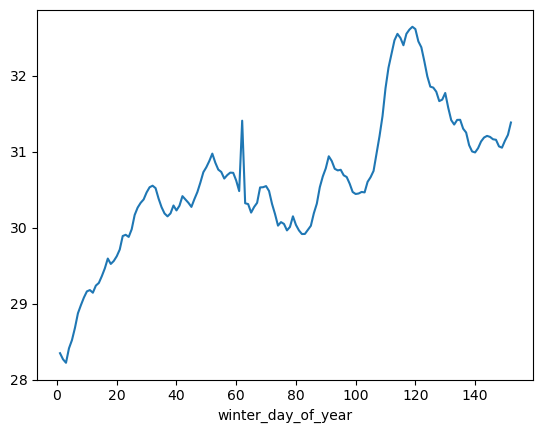

In [16]:
# plot the climatology for demand net wind
climatology_NDJFM["demand_net_wind"].plot()

In [17]:
# apply a 5 day rolling mean to the observed data
obs_df_smooth = obs_df.rolling(window="5D", min_periods=5, center=True).mean()

In [18]:
# subset obs_df_smooth to days of the year in NDJFM
obs_df_smooth_NDJFM_2011 = obs_df_smooth.loc[
    (obs_df_smooth.index >= "2010-11-01") & (obs_df_smooth.index <= "2011-03-31")
]

In [19]:
len(obs_df_smooth_NDJFM_2011.index)

151

In [20]:
len(climatology_NDJFM.index)

152

Text(0, 0.5, 'Demand Net Wind (GW)')

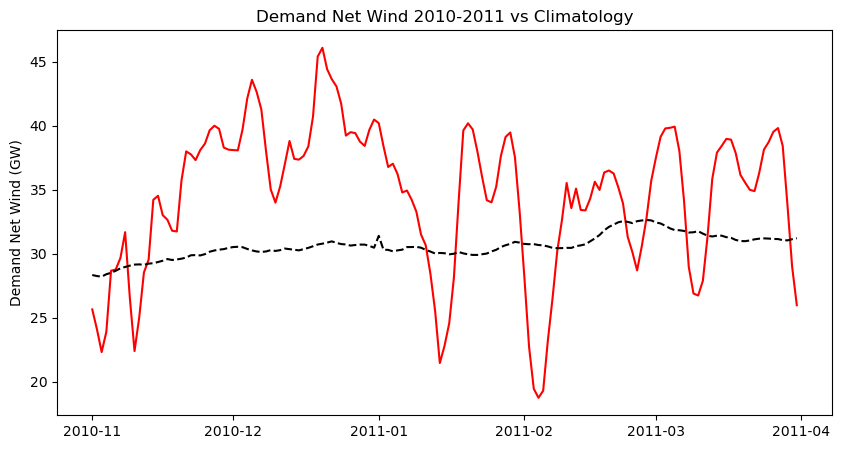

In [21]:
# Plot the demand net wind for 2010 relative to the climatology
# November 2010 -> March 2011
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the period of interest
plt.plot(
    obs_df_smooth_NDJFM_2011.index,
    obs_df_smooth_NDJFM_2011["demand_net_wind"],
    label="2010-2011",
    color="red",
)

# plot the climatology
plt.plot(
    obs_df_smooth_NDJFM_2011.index,
    climatology_NDJFM["demand_net_wind"][:-1],
    label="climatology",
    color="black",
    linestyle="--",
)

# set the title
plt.title("Demand Net Wind 2010-2011 vs Climatology")

# set the x-axis label
plt.ylabel("Demand Net Wind (GW)")

In [22]:
# Define this but corrected
uk_n_box_corrected = {"lon1": -27, "lon2": 21, "lat1": 57, "lat2": 70}

# Define this but corrected
uk_s_box_corrected = {"lon1": -27, "lon2": 21, "lat1": 38, "lat2": 51}

months to subset to: [3]
Returning the climatology


/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


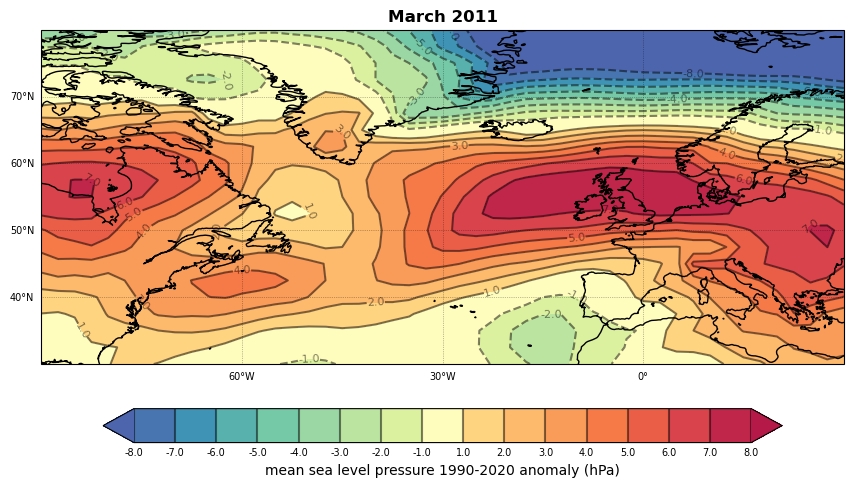

In [25]:
# test the function
mslp_clim_1990_2020 = plot_mslp_anoms(
    start_date="2011-03-01",
    end_date="2011-03-31",
    title="March 2011",
    calc_anoms=True,
)

In [24]:
mslp_clim_1990_2020

array([[101918.13 , 101918.625, 101931.28 , ..., 101853.78 , 101801.26 ,
        101774.28 ],
       [101962.61 , 101972.98 , 101980.44 , ..., 101784.164, 101752.41 ,
        101706.836],
       [101971.46 , 101993.94 , 102007.61 , ..., 101730.26 , 101663.45 ,
        101631.98 ],
       ...,
       [101306.92 , 101276.13 , 101165.74 , ..., 100432.54 , 100435.22 ,
        100445.22 ],
       [101385.29 , 101382.51 , 101397.85 , ..., 100665.74 , 100658.945,
        100657.55 ],
       [101280.87 , 101455.46 , 101452.4  , ..., 100823.59 , 100819.72 ,
        100816.34 ]], dtype=float32)

In [25]:
# set up a .npy name for the climatology array
climatology_npy = "obs_msl_climatology_NDJFM_1990_2020.npy"

# set up the folder to save to
save_dir = "/home/users/benhutch/unseen_multi_year/saved_clim"

# if the path does not exist, create it
if not os.path.exists(os.path.join(save_dir, climatology_npy)):
    np.save(os.path.join(save_dir, climatology_npy), mslp_clim_1990_2020)

/home/users/benhutch/.local/lib/python3.10/site-packages/xarray/core/groupby.py:509: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


nao values: [  4.3046093   -4.768828    -9.246328    -6.9653907   -5.543047
 -11.150234     0.84398437   0.08984375 -17.788828    -3.0152345
  -4.0465627    2.3071094    5.5640626    0.020625     1.7372656
   4.6228905   -6.312578    -1.9578906   -3.8277345    0.15171875
  -2.1464062   -1.3117969    8.933985     1.895       -3.733125
  -2.6809375    2.6276562   -1.36125      7.74625      6.2430468
   1.5214063    6.0351562    8.189922     6.741953     6.8765626
 -10.418125     0.65421873  -3.43375      6.2647657    7.1804686
  -5.2621093    1.4491407   -2.6717968   -1.9467969   -1.0313281
  -4.0710936    3.6260939    4.287578     3.9428124  -14.687656
  -6.4139843   10.995781    -9.096719     6.4753904   12.114688
   6.350859     3.367578     1.7261719           nan]


index values: ['1960' '1961' '1962' '1963' '1964' '1965' '1966' '1967' '1968' '1969'
 '1970' '1971' '1972' '1973' '1974' '1975' '1976' '1977' '1978' '1979'
 '1980' '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989'
 '1990' '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999'
 '2000' '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009'
 '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018']
type of index: <class 'str'>
index_percentile_nao: [1965, 1968, 2009]
variable is not wind, calculating the 95 percentile
energy_var min: -2.670944935879108
energy_var max: 2.6364662035553215
energy_percentile: 1.4150595110846893
index_percentile_energy: [1963, 1964, 2010]


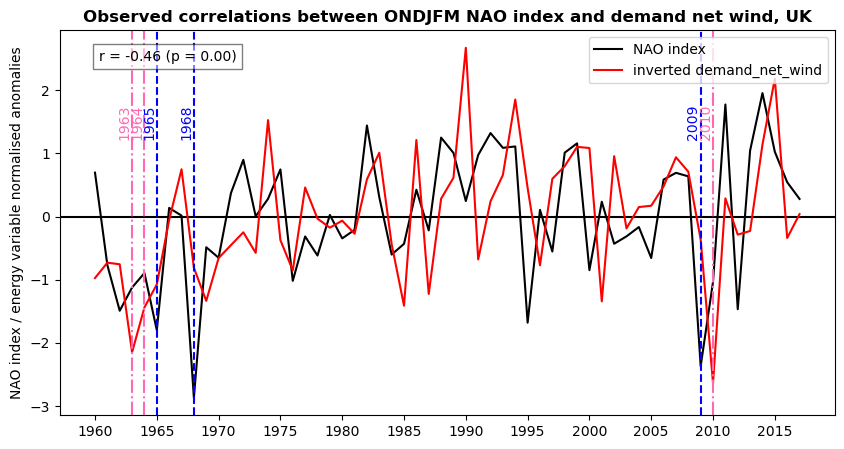

In [26]:
# plot the NAO correlations
plot_nao_ts_obs(
    start_date="1960-10-01",
    end_date="2018-03-31",
    title="Observed correlations between ONDJFM NAO index and demand net wind, UK",
    energy_variable="demand_net_wind",
    months=[10, 11, 12, 1, 2, 3],
    standardise_ts=True,
    invert_predictand=True,
    percentile_years=True,
)

In [27]:
import plotting_functions
from plotting_functions import plot_mslp_anoms_temp_wind_obs

In [28]:
importlib.reload(plotting_functions)

<module 'plotting_functions' from '/home/users/benhutch/unseen_multi_year/plotting_functions.py'>

months to subset to: [10, 11, 12, 1, 2, 3]
len of clevs_psl: 16
len of clevs_var: 20
field_var shape: (21, 49)
field_psl shape: (21, 49)
field_var values: [[-0.5303955  -0.7289429  -1.5181274  ...  0.81088257  0.6852417
   1.0194092 ]
 [-0.67089844 -0.81448364 -1.0232239  ...  0.6970825   0.8188782
   0.941803  ]
 [-0.50930786 -0.8347168  -0.8512573  ...  0.8060303   0.89694214
   0.86026   ]
 ...
 [ 3.0805664   2.7409058   2.699585   ... -0.21966553 -0.15856934
  -0.06359863]
 [ 0.3808899   2.2159424   2.9216614  ... -2.0563965  -1.6756897
  -1.3919983 ]
 [ 1.923645    1.8867798   2.5763245  ... -2.5547943  -3.0693054
  -2.7745667 ]]
field_psl values: [[-0.25507814 -0.30523437 -0.355625   ... -1.2869531  -1.1928906
  -1.1602343 ]
 [-0.47710937 -0.53703123 -0.6665625  ... -1.3145312  -1.0775781
  -0.9582813 ]
 [-0.57375    -0.6359375  -0.7778906  ... -1.1397656  -1.0529687
  -0.92046875]
 ...
 [ 0.98960936  1.1090626   1.31375    ...  1.6660937   1.4372656
   1.2127343 ]
 [ 1.0405469  

/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


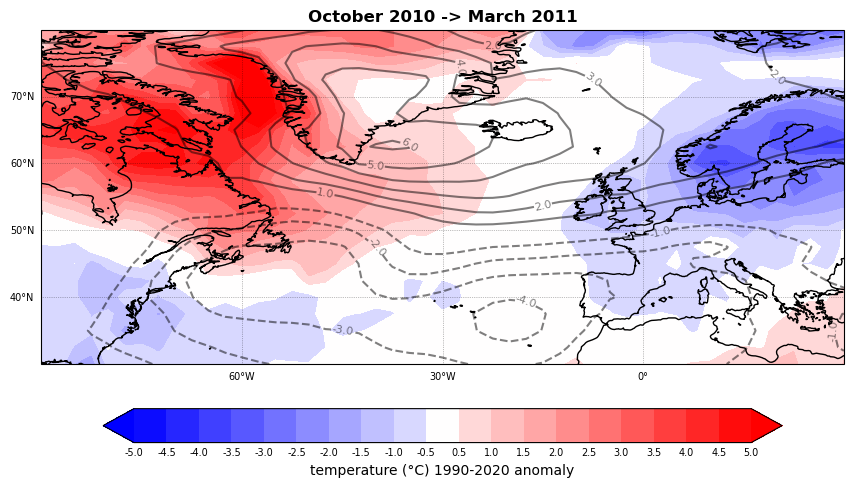

In [30]:
# default is t2m
var_clim, _ = plot_mslp_anoms_temp_wind_obs(
    start_date="2010-10-01",
    end_date="2011-03-31",
    title="October 2010 -> March 2011",
    variable="t2m",
    calc_anoms=True,
)

In [30]:
var_clim

array([[4.1837306, 6.4836364, 2.9685018, ..., 4.098091 , 3.5168204,
        4.246669 ],
       [3.1167169, 3.0274022, 2.9083982, ..., 6.550092 , 6.626351 ,
        6.2235   ],
       [3.2556958, 3.1777444, 2.8812304, ..., 2.5631897, 7.1729383,
        5.919146 ],
       ...,
       [4.2522655, 3.68624  , 3.3299663, ..., 9.082701 , 9.383665 ,
        9.511624 ],
       [3.794845 , 3.4414818, 2.0765948, ..., 8.029709 , 8.124185 ,
        8.221894 ],
       [3.0196075, 1.8131576, 2.2280743, ..., 6.6096177, 7.3183413,
        8.294321 ]], dtype=float32)

In [31]:
# set up a .npy name for the climatology array
climatology_npy = "obs_si10_climatology_NDJFM_1990_2020.npy"

# set up the folder to save to
save_dir = "/home/users/benhutch/unseen_multi_year/saved_clim"

# if the path does not exist, create it
if not os.path.exists(os.path.join(save_dir, climatology_npy)):
    np.save(os.path.join(save_dir, climatology_npy), var_clim)

months to subset to: [11, 12, 1, 2, 3]
len of clevs_psl: 16
len of clevs_var: 14
field_var shape: (21, 49)
field_psl shape: (21, 49)
field_var values: [[ 0.14865208  0.10439825  0.04114795 ... -0.10879207 -0.19659328
  -0.03887939]
 [ 0.07692099  0.04863048  0.09482479 ...  0.01853943 -0.10482359
   0.10592794]
 [ 0.08031654  0.01988626  0.02366614 ... -0.01291895  0.08741236
   0.41439962]
 ...
 [ 0.34034634  0.29357576 -0.06489182 ...  0.1702652  -0.1440506
  -0.25142002]
 [ 0.6042948   0.34174275  0.34265685 ...  0.23749352  0.30722904
   0.28650856]
 [-0.30132008 -0.13191879  0.10457969 ... -0.08989954  0.05724382
  -0.1721754 ]]
field_psl values: [[-0.23757812 -0.20773438 -0.16296875 ... -1.5066407  -1.3564844
  -1.3026563 ]
 [-0.09117188 -0.07257812 -0.09390625 ... -1.574375   -1.5045313
  -1.3966407 ]
 [-0.03882812 -0.0865625  -0.20296875 ... -1.5829687  -1.5442188
  -1.3757813 ]
 ...
 [ 1.8945312   2.051953    2.229453   ...  0.6785156   0.6596094
   0.68359375]
 [ 2.355547    

/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Returning the climatology


(array([[4.1837306, 6.4836364, 2.9685018, ..., 4.098091 , 3.5168204,
         4.246669 ],
        [3.1167169, 3.0274022, 2.9083982, ..., 6.550092 , 6.626351 ,
         6.2235   ],
        [3.2556958, 3.1777444, 2.8812304, ..., 2.5631897, 7.1729383,
         5.919146 ],
        ...,
        [4.2522655, 3.68624  , 3.3299663, ..., 9.082701 , 9.383665 ,
         9.511624 ],
        [3.794845 , 3.4414818, 2.0765948, ..., 8.029709 , 8.124185 ,
         8.221894 ],
        [3.0196075, 1.8131576, 2.2280743, ..., 6.6096177, 7.3183413,
         8.294321 ]], dtype=float32),
 array([[101968.016, 101970.32 , 101985.32 , ..., 101896.625, 101848.88 ,
         101820.69 ],
        [102006.28 , 102017.45 , 102022.1  , ..., 101812.75 , 101783.64 ,
         101743.05 ],
        [102010.27 , 102029.836, 102041.31 , ..., 101747.78 , 101688.65 ,
         101665.31 ],
        ...,
        [101289.4  , 101255.69 , 101133.695, ..., 100363.836, 100369.805,
         100384.375],
        [101366.72 , 101363.484, 

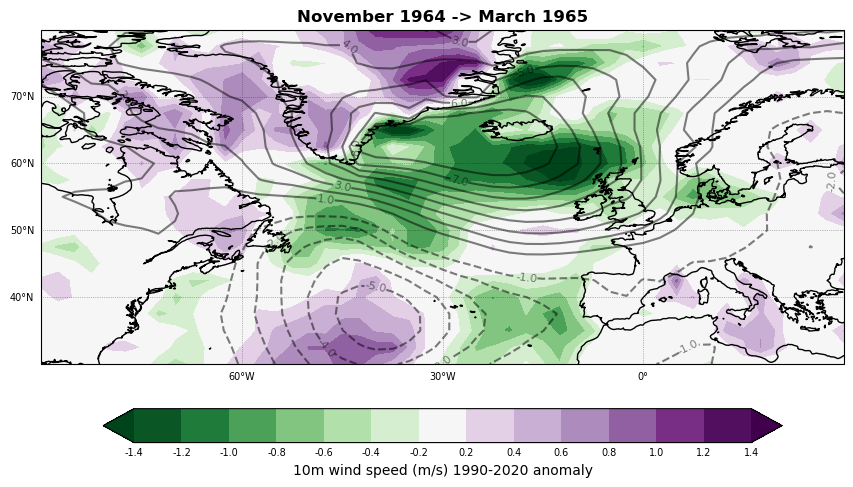

In [32]:
# default is t2m
plot_mslp_anoms_temp_wind_obs(
    start_date="1964-11-01",
    end_date="1965-03-31",
    title="November 1964 -> March 1965",
    variable="si10",
    calc_anoms=True,
)

months to subset to: [11, 12, 1, 2, 3]
Returning the climatology


/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


array([[101968.016, 101970.32 , 101985.32 , ..., 101896.625, 101848.88 ,
        101820.69 ],
       [102006.28 , 102017.45 , 102022.1  , ..., 101812.75 , 101783.64 ,
        101743.05 ],
       [102010.27 , 102029.836, 102041.31 , ..., 101747.78 , 101688.65 ,
        101665.31 ],
       ...,
       [101289.4  , 101255.69 , 101133.695, ..., 100363.836, 100369.805,
        100384.375],
       [101366.72 , 101363.484, 101376.97 , ..., 100614.29 , 100610.3  ,
        100612.22 ],
       [101243.99 , 101430.28 , 101425.78 , ..., 100774.95 , 100777.19 ,
        100776.53 ]], dtype=float32)

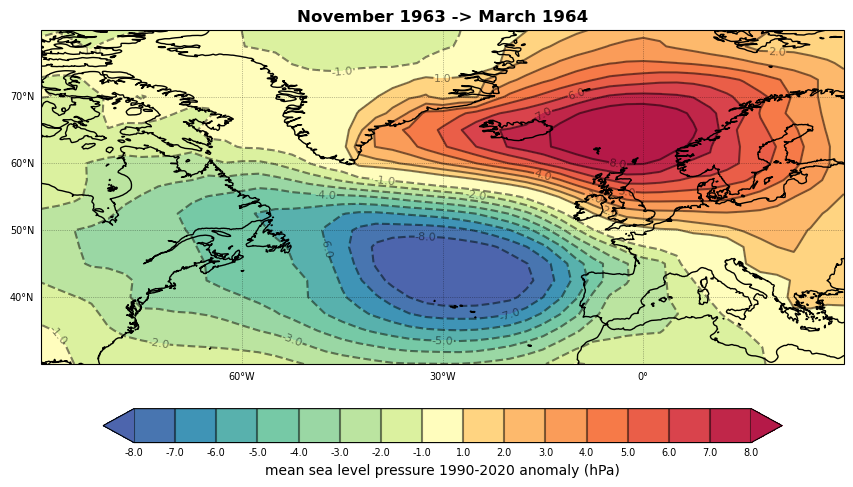

In [33]:
# 1963 was also bad
plot_mslp_anoms(
    start_date="1963-11-01",
    end_date="1964-03-31",
    title="November 1963 -> March 1964",
    calc_anoms=True,
)

months to subset to: [11, 12, 1, 2, 3]
Returning the climatology


/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


array([[101968.016, 101970.32 , 101985.32 , ..., 101896.625, 101848.88 ,
        101820.69 ],
       [102006.28 , 102017.45 , 102022.1  , ..., 101812.75 , 101783.64 ,
        101743.05 ],
       [102010.27 , 102029.836, 102041.31 , ..., 101747.78 , 101688.65 ,
        101665.31 ],
       ...,
       [101289.4  , 101255.69 , 101133.695, ..., 100363.836, 100369.805,
        100384.375],
       [101366.72 , 101363.484, 101376.97 , ..., 100614.29 , 100610.3  ,
        100612.22 ],
       [101243.99 , 101430.28 , 101425.78 , ..., 100774.95 , 100777.19 ,
        100776.53 ]], dtype=float32)

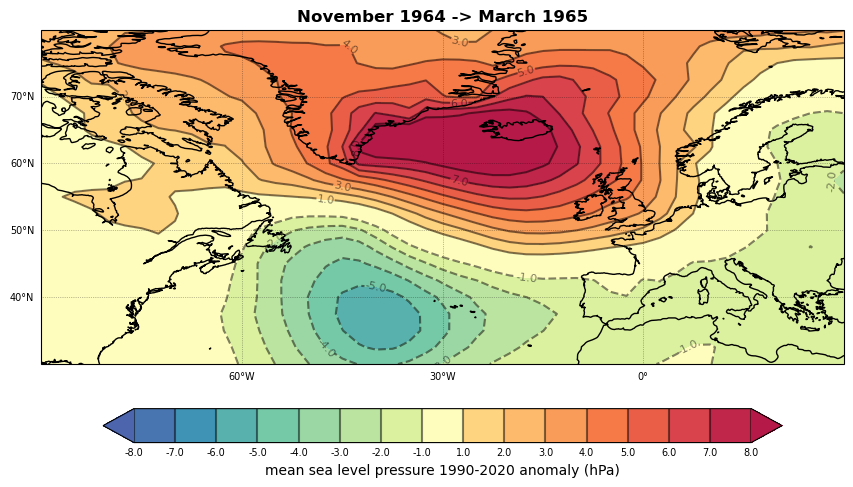

In [34]:
# 1964 to 1965 was also bad
plot_mslp_anoms(
    start_date="1964-11-01",
    end_date="1965-03-31",
    title="November 1964 -> March 1965",
    calc_anoms=True,
)

In [35]:
# # now plot the composite of the 95%tile of demand net wind NDJFM winters
# # for the observed data
# # Set up the constsnats
# title = "MSLP composites for the 95th percentile of demand-net-wind events, observations"
# energy_variable = "demand_net_wind"
# percentile = 0.95

# # Call the function
# plot_composite_obs(
#     title=title,
#     energy_variable=energy_variable,
#     percentile=percentile,
#     calc_anoms=True,
# )

In [36]:
# # now plot the composite of the 95%tile of demand net wind NDJFM winters
# # for the observed data
# # Set up the constsnats
# title = "Temp composite for the 95th percentile of demand-net-wind events, observations"
# energy_variable = "demand_net_wind"
# percentile = 0.95

# # Call the function
# plot_composite_var_obs(
#     title=title,
#     energy_variable=energy_variable,
#     percentile=percentile,
#     sf_variable="si10",
#     calc_anoms=True,
# )

In [37]:
# # now plot the composite of the 95%tile of demand net wind NDJFM winters
# # for the observed data
# # Set up the constsnats
# title = "MSLP composites for the 95th percentile of demand events, observations"
# energy_variable = "demand"
# percentile = 0.95

# # Call the function
# plot_composite_obs(
#     title=title,
#     energy_variable=energy_variable,
#     percentile=percentile,
#     calc_anoms=True,
# )

In [38]:
# # now plot the composite of the 95%tile of demand net wind NDJFM winters
# # for the observed data
# # Set up the constsnats
# title = "MSLP composites for the 5th percentile of wind events, observations"
# energy_variable = "wind"
# percentile = 0.05

# # Call the function
# plot_composite_obs(
#     title=title,
#     energy_variable=energy_variable,
#     percentile=percentile,
#     calc_anoms=True,
# )

## Synoptic outlook for model data ##

Do the same but using the HadGEM3-GC31-MM MSLP data instead. Can plot with daily or monthly data.

Maybe use monthly for anomalies?

In [39]:
# # plot the composite of the 95th percentile of demand net wind NDJFM winters
# # Set up the constsnats
# title = "MSLP/temp composites for the 99.5th percentile of demand-net-wind events, model"
# energy_variable = "demand_net_wind"
# percentile = 0.995

# # Call the function
# plot_composite_var_model(
#     title=title,
#     energy_variable=energy_variable,
#     percentile=percentile,
#     sf_variable="sfcWind",
#     calc_anoms=True,
# )

In [40]:
# # plot the composite of the 95th percentile of demand net wind NDJFM winters
# # Set up the constsnats
# title = "MSLP composites for the 99.5th percentile of demand-net-wind events, model"
# energy_variable = "demand_net_wind"
# percentile = 0.995

# # Call the function
# plot_composite_model(
#     title=title,
#     energy_variable=energy_variable,
#     percentile=percentile,
#     calc_anoms=True,
# )

In [41]:
importlib.reload(plotting_functions)

from plotting_functions import plot_mslp_var_model

In [42]:
import warnings

# suppress warnings
warnings.filterwarnings("ignore")

model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
variable: sfcWind
frequency: Amon
Using non-bias corrected fields directly from /badc/ archive
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files/sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1992-r9i*_*_1992??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/sfcWind/HadGEM3-GC31-MM/merged_files/sfcWind_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1992-r9i1p1f2_gn_199211-200303.nc
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1992-r9i*_*_1992??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1992-r9i1_gn_199211-200303.nc


Caculating the climatology for the model data


100%|██████████| 31/31 [00:03<00:00, 10.21it/s]


len of clevs_psl: 16
len of clevs_var: 14
field_var shape: (21, 49)
field_psl shape: (21, 49)
field_var values: [[0.38367843097051857 0.8759159602133373 0.6121096717198506 ...
  -0.5163783684070884 -0.6357095581852912 -0.4334097119559228]
 [0.10454794008188051 0.14815670464537734 0.2621693245656074 ...
  0.0855926200045607 0.13971253432378106 0.30197809098483575]
 [0.08699307453962435 0.15332132164423973 0.060364175584702195 ...
  0.7803678123262858 0.5934824147225788 1.1419028752604925]
 ...
 [-0.3661144187441563 -0.2561269376810844 0.14528794830402836 ...
  1.0361990821113114 0.9025531295636977 0.7876328074384205]
 [-0.154035538834842 -0.14553813814538352 -0.032559857789087765 ...
  0.8059683397365509 0.9436129792703749 0.8386818670457412]
 [0.016888687585443485 -0.08188111983535284 -0.40383911119200255 ...
  -0.3831835873903562 -0.3325580094087268 0.15468459656127642]]
field_psl values: [[-0.11126224396939506 -0.4327637694476289 -0.5719672423637531 ...
  0.9187030090279587 1.3716102

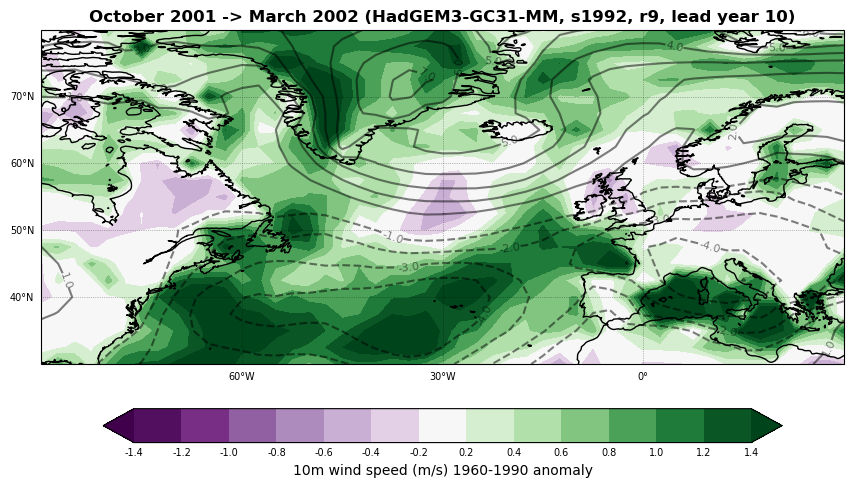

In [48]:
# test the new function
plot_mslp_var_model(
    init_year=1992,
    months=[10, 11, 12, 1, 2, 3],
    lead_year=10,
    member=9,
    title="October 2001 -> March 2002 (HadGEM3-GC31-MM, s1992, r9, lead year 10)",
    sf_variable="sfcWind",
    calc_anoms=True,
    # saved_clim_var_path="/home/users/benhutch/unseen_multi_year/saved_clim/obs_t2m_climatology_NDJFM_1990_2020.npy",
    # saved_clim_psl_path="/home/users/benhutch/unseen_multi_year/saved_clim/obs_msl_climatology_NDJFM_1990_2020.npy",
)

model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
variable: psl
frequency: Amon
Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM
Model path root: gws
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1992-r9i*_*_1992??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1992-r9i1_gn_199211-200303.nc
Caculating the climatology for the model data


100%|██████████| 31/31 [00:03<00:00,  9.42it/s]


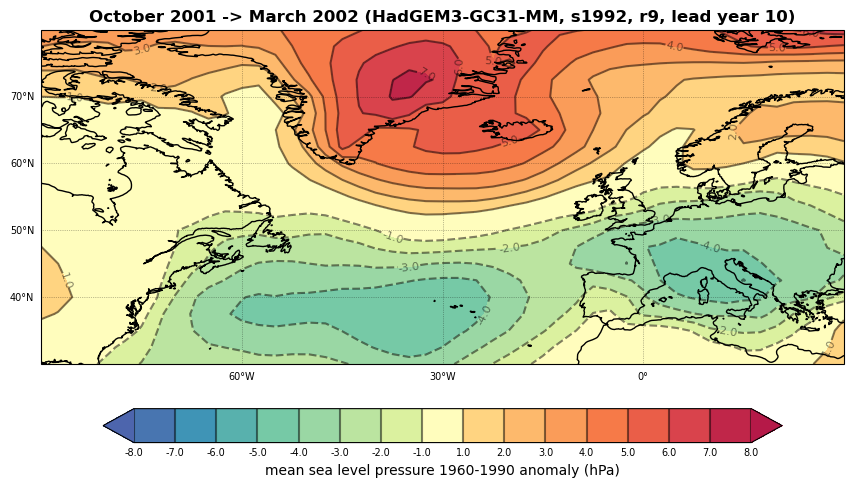

In [49]:
# test the function
plot_mslp_anoms_model(
    init_year=1992,
    months=[10, 11, 12, 1, 2, 3],
    lead_year=10,
    member=9,
    title="October 2001 -> March 2002 (HadGEM3-GC31-MM, s1992, r9, lead year 10)",
    calc_anoms=True,
    climatology_period=[1960, 1990],
    # saved_clim_path="/home/users/benhutch/unseen_multi_year/saved_clim/obs_msl_climatology_NDJFM_1990_2020.npy",
)

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(


model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
variable: psl
frequency: Amon
Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM
Model path root: gws
start year: 1965
end year: 1966
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1965-r2i*_*_1965??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1965-r2i1_gn_196511-197603.nc
Caculating the climatology for the model data


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:14<00:00,  2.12it/s]
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right a

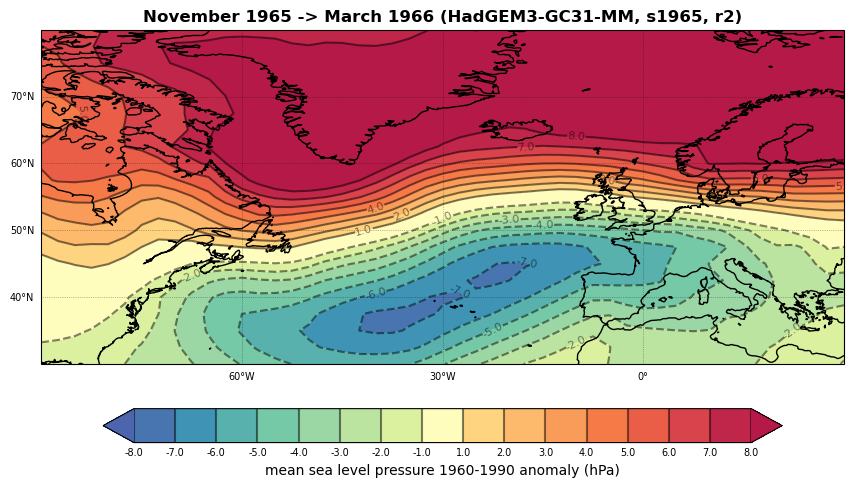

In [ ]:
# test the function
plot_mslp_anoms_model(
    start_date="1965-11-01",
    end_date="1966-03-30",
    member="2",
    title="November 1965 -> March 1966 (HadGEM3-GC31-MM, s1965, r2)",
    calc_anoms=True,
)

In [ ]:
import dictionaries_umy as dicts_umy

In [ ]:
# extract the 1th event
event = dicts_umy.model_dnw_purple_events[1]

model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
variable: psl
frequency: Amon
Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM
Model path root: gws
start year: 1963
end year: 1964
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i*_*_1963??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i1_gn_196311-197403.nc


/home/users/benhutch/.local/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


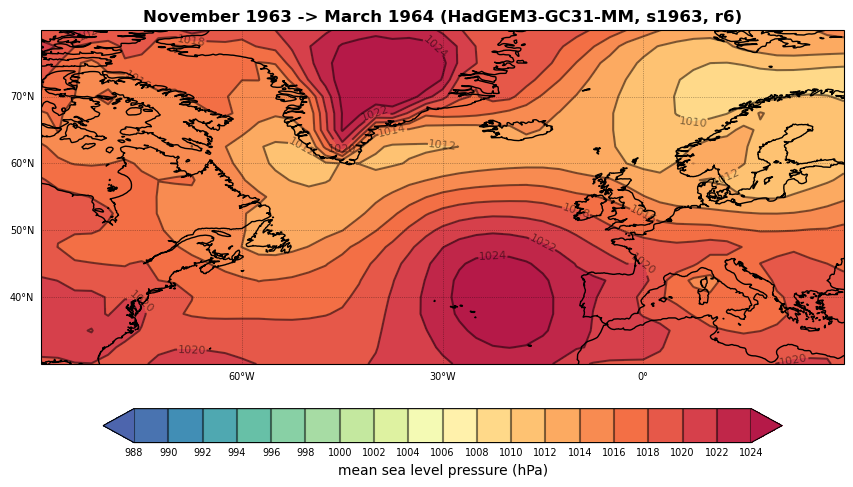

In [ ]:
# plot the absolute values for this event
plot_mslp_anoms_model(
    start_date=event["start_date"],
    end_date=event["end_date"],
    member=event["member"],
    title="November 1963 -> March 1964 (HadGEM3-GC31-MM, s1963, r6)",
    calc_anoms=False,
)

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(


model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
variable: psl
frequency: Amon
Model path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM
Model path root: gws
start year: 1963
end year: 1964
path: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i*_*_1963??-*.nc
Loaded file: /gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1963-r6i1_gn_196311-197403.nc
Caculating the climatology for the model data


100%|██████████| 31/31 [00:08<00:00,  3.57it/s]
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/users/benhutch/.local/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right a

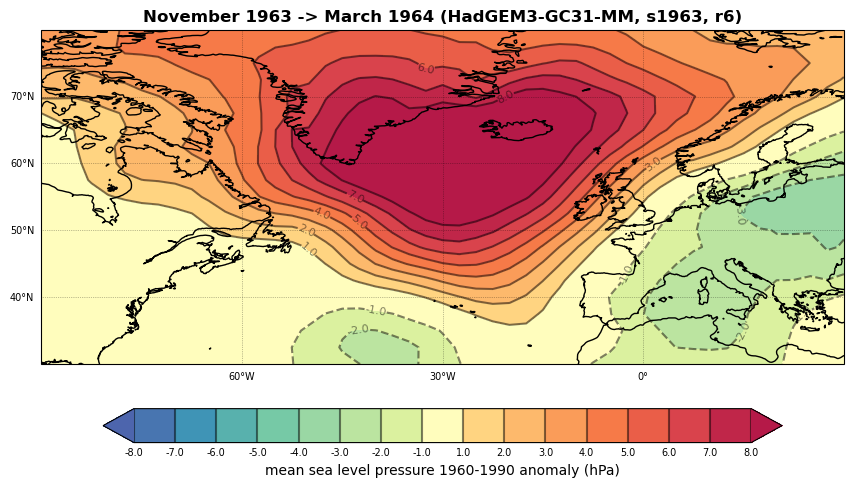

In [ ]:
# Now plot the anomalies
plot_mslp_anoms_model(
    start_date=event["start_date"],
    end_date=event["end_date"],
    member=event["member"],
    title="November 1963 -> March 1964 (HadGEM3-GC31-MM, s1963, r6)",
    calc_anoms=True,
)